In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "RHann"
station_dv = "mean RH (%)"
station_path = "data/station_inputs/rh_annual_mean_10yr_for_maps.csv"
input_model_path = "data/model_inputs/hurs_CanRCM4-LE_ens15_1951-2016_ensmean.nc"
medians = {"value": "None", "action": "None"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,mean RH (%),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,75.0,-4.517790,10.457750,42.0333,-82.9000,191.0,HARROW CDA AUTO,ON,82.043449,1.020425
1,558,1009,71.0,-4.286849,10.373390,42.2756,-82.9556,190.0,WINDSOR A,ON,81.802795,0.968844
2,560,1026,76.0,-4.166610,11.147744,42.2501,-81.9001,178.0,ERIEAU (AUT),ON,82.289291,1.030941


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

77.4

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/550 [00:00<?, ?it/s]

  0%|          | 2/550 [00:00<02:59,  3.06it/s]

  1%|          | 3/550 [00:01<04:01,  2.26it/s]

  1%|          | 4/550 [00:01<04:30,  2.02it/s]

  1%|          | 5/550 [00:02<04:59,  1.82it/s]

  1%|          | 6/550 [00:03<05:14,  1.73it/s]

  1%|▏         | 7/550 [00:03<05:26,  1.67it/s]

  1%|▏         | 8/550 [00:04<05:40,  1.59it/s]

  2%|▏         | 9/550 [00:05<05:47,  1.56it/s]

  2%|▏         | 10/550 [00:05<05:46,  1.56it/s]

  2%|▏         | 11/550 [00:06<05:55,  1.52it/s]

  2%|▏         | 12/550 [00:07<05:59,  1.49it/s]

  2%|▏         | 13/550 [00:08<06:01,  1.48it/s]

  3%|▎         | 14/550 [00:08<05:46,  1.55it/s]

  3%|▎         | 15/550 [00:09<05:40,  1.57it/s]

  3%|▎         | 16/550 [00:09<05:35,  1.59it/s]

  3%|▎         | 17/550 [00:10<05:28,  1.62it/s]

  3%|▎         | 18/550 [00:11<05:22,  1.65it/s]

  3%|▎         | 19/550 [00:11<05:18,  1.67it/s]

  4%|▎         | 20/550 [00:12<05:17,  1.67it/s]

  4%|▍         | 21/550 [00:12<05:18,  1.66it/s]

  4%|▍         | 22/550 [00:13<05:20,  1.65it/s]

  4%|▍         | 23/550 [00:14<05:25,  1.62it/s]

  4%|▍         | 24/550 [00:14<05:25,  1.62it/s]

  5%|▍         | 25/550 [00:15<05:17,  1.65it/s]

  5%|▍         | 26/550 [00:15<05:27,  1.60it/s]

  5%|▍         | 27/550 [00:16<05:29,  1.59it/s]

  5%|▌         | 28/550 [00:17<05:27,  1.59it/s]

  5%|▌         | 29/550 [00:17<05:26,  1.60it/s]

  5%|▌         | 30/550 [00:18<05:20,  1.62it/s]

  6%|▌         | 31/550 [00:19<05:18,  1.63it/s]

  6%|▌         | 32/550 [00:19<05:15,  1.64it/s]

  6%|▌         | 33/550 [00:20<05:17,  1.63it/s]

  6%|▌         | 34/550 [00:20<05:16,  1.63it/s]

  6%|▋         | 35/550 [00:21<05:15,  1.63it/s]

  7%|▋         | 36/550 [00:22<05:16,  1.63it/s]

  7%|▋         | 37/550 [00:22<05:11,  1.65it/s]

  7%|▋         | 38/550 [00:23<05:13,  1.63it/s]

  7%|▋         | 39/550 [00:23<05:15,  1.62it/s]

  7%|▋         | 40/550 [00:24<05:20,  1.59it/s]

  7%|▋         | 41/550 [00:25<05:16,  1.61it/s]

  8%|▊         | 42/550 [00:25<05:19,  1.59it/s]

  8%|▊         | 43/550 [00:26<05:26,  1.55it/s]

  8%|▊         | 44/550 [00:27<05:26,  1.55it/s]

  8%|▊         | 45/550 [00:27<05:17,  1.59it/s]

  8%|▊         | 46/550 [00:28<05:17,  1.59it/s]

  9%|▊         | 47/550 [00:29<05:16,  1.59it/s]

  9%|▊         | 48/550 [00:29<05:22,  1.56it/s]

  9%|▉         | 49/550 [00:30<05:16,  1.58it/s]

  9%|▉         | 50/550 [00:30<05:12,  1.60it/s]

  9%|▉         | 51/550 [00:31<05:08,  1.62it/s]

  9%|▉         | 52/550 [00:32<05:06,  1.63it/s]

 10%|▉         | 53/550 [00:32<05:12,  1.59it/s]

 10%|▉         | 54/550 [00:33<05:11,  1.59it/s]

 10%|█         | 55/550 [00:34<05:16,  1.56it/s]

 10%|█         | 56/550 [00:34<05:12,  1.58it/s]

 10%|█         | 57/550 [00:35<05:12,  1.58it/s]

 11%|█         | 58/550 [00:35<05:11,  1.58it/s]

 11%|█         | 59/550 [00:36<05:08,  1.59it/s]

 11%|█         | 60/550 [00:37<05:06,  1.60it/s]

 11%|█         | 61/550 [00:37<05:03,  1.61it/s]

 11%|█▏        | 62/550 [00:38<05:04,  1.60it/s]

 11%|█▏        | 63/550 [00:39<05:04,  1.60it/s]

 12%|█▏        | 64/550 [00:39<05:01,  1.61it/s]

 12%|█▏        | 65/550 [00:40<04:59,  1.62it/s]

 12%|█▏        | 66/550 [00:40<04:59,  1.62it/s]

 12%|█▏        | 67/550 [00:41<05:00,  1.61it/s]

 12%|█▏        | 68/550 [00:42<05:15,  1.53it/s]

 13%|█▎        | 69/550 [00:43<05:34,  1.44it/s]

 13%|█▎        | 70/550 [00:43<05:33,  1.44it/s]

 13%|█▎        | 71/550 [00:44<05:24,  1.48it/s]

 13%|█▎        | 72/550 [00:44<05:13,  1.53it/s]

 13%|█▎        | 73/550 [00:45<05:06,  1.55it/s]

 13%|█▎        | 74/550 [00:46<05:01,  1.58it/s]

 14%|█▎        | 75/550 [00:46<05:04,  1.56it/s]

 14%|█▍        | 76/550 [00:47<05:01,  1.57it/s]

 14%|█▍        | 77/550 [00:48<04:53,  1.61it/s]

 14%|█▍        | 78/550 [00:48<04:53,  1.61it/s]

 14%|█▍        | 79/550 [00:49<04:51,  1.62it/s]

 15%|█▍        | 80/550 [00:49<04:55,  1.59it/s]

 15%|█▍        | 81/550 [00:50<04:52,  1.60it/s]

 15%|█▍        | 82/550 [00:51<04:48,  1.62it/s]

 15%|█▌        | 83/550 [00:51<04:48,  1.62it/s]

 15%|█▌        | 84/550 [00:52<04:46,  1.63it/s]

 15%|█▌        | 85/550 [00:53<04:47,  1.62it/s]

 16%|█▌        | 86/550 [00:53<04:41,  1.65it/s]

 16%|█▌        | 87/550 [00:54<04:53,  1.58it/s]

 16%|█▌        | 88/550 [00:54<04:51,  1.59it/s]

 16%|█▌        | 89/550 [00:55<04:47,  1.60it/s]

 16%|█▋        | 90/550 [00:56<05:13,  1.47it/s]

 17%|█▋        | 91/550 [00:56<05:01,  1.52it/s]

 17%|█▋        | 92/550 [00:57<04:57,  1.54it/s]

 17%|█▋        | 93/550 [00:58<04:53,  1.56it/s]

 17%|█▋        | 94/550 [00:58<04:48,  1.58it/s]

 17%|█▋        | 95/550 [00:59<04:46,  1.59it/s]

 17%|█▋        | 96/550 [01:00<04:58,  1.52it/s]

 18%|█▊        | 97/550 [01:00<04:50,  1.56it/s]

 18%|█▊        | 98/550 [01:01<04:50,  1.55it/s]

 18%|█▊        | 99/550 [01:01<04:39,  1.61it/s]

 18%|█▊        | 100/550 [01:02<04:33,  1.65it/s]

 18%|█▊        | 101/550 [01:03<04:39,  1.61it/s]

 19%|█▊        | 102/550 [01:03<04:34,  1.63it/s]

 19%|█▊        | 103/550 [01:04<04:37,  1.61it/s]

 19%|█▉        | 104/550 [01:05<04:37,  1.61it/s]

 19%|█▉        | 105/550 [01:05<04:38,  1.60it/s]

 19%|█▉        | 106/550 [01:06<04:39,  1.59it/s]

 19%|█▉        | 107/550 [01:06<04:37,  1.59it/s]

 20%|█▉        | 108/550 [01:07<04:35,  1.61it/s]

 20%|█▉        | 109/550 [01:08<04:34,  1.61it/s]

 20%|██        | 110/550 [01:08<04:32,  1.62it/s]

 20%|██        | 111/550 [01:09<04:26,  1.64it/s]

 20%|██        | 112/550 [01:10<04:27,  1.64it/s]

 21%|██        | 113/550 [01:10<04:24,  1.66it/s]

 21%|██        | 114/550 [01:11<04:25,  1.64it/s]

 21%|██        | 115/550 [01:11<04:25,  1.64it/s]

 21%|██        | 116/550 [01:12<04:25,  1.63it/s]

 21%|██▏       | 117/550 [01:13<04:29,  1.61it/s]

 21%|██▏       | 118/550 [01:13<04:30,  1.60it/s]

 22%|██▏       | 119/550 [01:14<04:31,  1.59it/s]

 22%|██▏       | 120/550 [01:15<04:30,  1.59it/s]

 22%|██▏       | 121/550 [01:15<04:27,  1.60it/s]

 22%|██▏       | 122/550 [01:16<04:25,  1.61it/s]

 22%|██▏       | 123/550 [01:16<04:26,  1.60it/s]

 23%|██▎       | 124/550 [01:17<04:23,  1.62it/s]

 23%|██▎       | 125/550 [01:17<04:10,  1.69it/s]

 23%|██▎       | 126/550 [01:18<04:06,  1.72it/s]

 23%|██▎       | 127/550 [01:19<04:05,  1.73it/s]

 23%|██▎       | 128/550 [01:19<04:07,  1.70it/s]

 23%|██▎       | 129/550 [01:20<04:09,  1.69it/s]

 24%|██▎       | 130/550 [01:20<04:03,  1.72it/s]

 24%|██▍       | 131/550 [01:21<04:02,  1.73it/s]

 24%|██▍       | 132/550 [01:22<04:00,  1.74it/s]

 24%|██▍       | 133/550 [01:22<04:01,  1.72it/s]

 24%|██▍       | 134/550 [01:23<04:03,  1.71it/s]

 25%|██▍       | 135/550 [01:23<04:04,  1.70it/s]

 25%|██▍       | 136/550 [01:24<04:34,  1.51it/s]

 25%|██▍       | 137/550 [01:25<04:29,  1.53it/s]

 25%|██▌       | 138/550 [01:25<04:30,  1.52it/s]

 25%|██▌       | 139/550 [01:26<04:25,  1.55it/s]

 25%|██▌       | 140/550 [01:27<04:17,  1.59it/s]

 26%|██▌       | 141/550 [01:27<04:25,  1.54it/s]

 26%|██▌       | 142/550 [01:28<04:18,  1.58it/s]

 26%|██▌       | 143/550 [01:29<04:14,  1.60it/s]

 26%|██▌       | 144/550 [01:29<04:06,  1.65it/s]

 26%|██▋       | 145/550 [01:30<04:05,  1.65it/s]

 27%|██▋       | 146/550 [01:30<04:04,  1.65it/s]

 27%|██▋       | 147/550 [01:31<03:59,  1.68it/s]

 27%|██▋       | 148/550 [01:31<04:00,  1.67it/s]

 27%|██▋       | 149/550 [01:32<04:02,  1.65it/s]

 27%|██▋       | 150/550 [01:33<04:22,  1.52it/s]

 27%|██▋       | 151/550 [01:34<04:19,  1.54it/s]

 28%|██▊       | 152/550 [01:34<04:22,  1.52it/s]

 28%|██▊       | 153/550 [01:35<04:13,  1.57it/s]

 28%|██▊       | 154/550 [01:35<04:13,  1.56it/s]

 28%|██▊       | 155/550 [01:36<04:05,  1.61it/s]

 28%|██▊       | 156/550 [01:37<04:02,  1.62it/s]

 29%|██▊       | 157/550 [01:37<04:21,  1.50it/s]

 29%|██▊       | 158/550 [01:38<04:12,  1.56it/s]

 29%|██▉       | 159/550 [01:39<04:05,  1.59it/s]

 29%|██▉       | 160/550 [01:39<04:03,  1.60it/s]

 29%|██▉       | 161/550 [01:40<04:01,  1.61it/s]

 29%|██▉       | 162/550 [01:40<03:58,  1.63it/s]

 30%|██▉       | 163/550 [01:41<03:58,  1.62it/s]

 30%|██▉       | 164/550 [01:42<03:57,  1.63it/s]

 30%|███       | 165/550 [01:42<03:56,  1.63it/s]

 30%|███       | 166/550 [01:43<03:59,  1.60it/s]

 30%|███       | 167/550 [01:44<04:02,  1.58it/s]

 31%|███       | 168/550 [01:44<03:56,  1.62it/s]

 31%|███       | 169/550 [01:45<03:54,  1.63it/s]

 31%|███       | 170/550 [01:45<03:49,  1.66it/s]

 31%|███       | 171/550 [01:46<03:47,  1.66it/s]

 31%|███▏      | 172/550 [01:47<03:46,  1.67it/s]

 31%|███▏      | 173/550 [01:47<03:46,  1.66it/s]

 32%|███▏      | 174/550 [01:48<03:48,  1.64it/s]

 32%|███▏      | 175/550 [01:48<03:46,  1.66it/s]

 32%|███▏      | 176/550 [01:49<03:44,  1.67it/s]

 32%|███▏      | 177/550 [01:50<03:44,  1.66it/s]

 32%|███▏      | 178/550 [01:50<03:43,  1.66it/s]

 33%|███▎      | 179/550 [01:51<03:46,  1.64it/s]

 33%|███▎      | 180/550 [01:51<03:47,  1.63it/s]

 33%|███▎      | 181/550 [01:52<03:49,  1.61it/s]

 33%|███▎      | 182/550 [01:53<03:46,  1.63it/s]

 33%|███▎      | 183/550 [01:53<03:48,  1.61it/s]

 33%|███▎      | 184/550 [01:54<03:44,  1.63it/s]

 34%|███▎      | 185/550 [01:54<03:41,  1.64it/s]

 34%|███▍      | 186/550 [01:55<03:38,  1.67it/s]

 34%|███▍      | 187/550 [01:56<03:36,  1.68it/s]

 34%|███▍      | 188/550 [01:56<03:37,  1.66it/s]

 34%|███▍      | 189/550 [01:57<03:41,  1.63it/s]

 35%|███▍      | 190/550 [01:58<03:46,  1.59it/s]

 35%|███▍      | 191/550 [01:58<03:48,  1.57it/s]

 35%|███▍      | 192/550 [01:59<03:45,  1.59it/s]

 35%|███▌      | 193/550 [01:59<03:48,  1.56it/s]

 35%|███▌      | 194/550 [02:00<03:45,  1.58it/s]

 35%|███▌      | 195/550 [02:01<03:41,  1.60it/s]

 36%|███▌      | 196/550 [02:01<03:36,  1.63it/s]

 36%|███▌      | 197/550 [02:02<03:34,  1.65it/s]

 36%|███▌      | 198/550 [02:03<03:35,  1.63it/s]

 36%|███▌      | 199/550 [02:03<03:36,  1.62it/s]

 36%|███▋      | 200/550 [02:04<03:37,  1.61it/s]

 37%|███▋      | 201/550 [02:04<03:36,  1.62it/s]

 37%|███▋      | 202/550 [02:05<03:36,  1.61it/s]

 37%|███▋      | 203/550 [02:06<03:31,  1.64it/s]

 37%|███▋      | 204/550 [02:06<03:34,  1.61it/s]

 37%|███▋      | 205/550 [02:07<03:33,  1.62it/s]

 37%|███▋      | 206/550 [02:07<03:31,  1.63it/s]

 38%|███▊      | 207/550 [02:08<03:31,  1.62it/s]

 38%|███▊      | 208/550 [02:09<03:28,  1.64it/s]

 38%|███▊      | 209/550 [02:09<03:30,  1.62it/s]

 38%|███▊      | 210/550 [02:10<03:28,  1.63it/s]

 38%|███▊      | 211/550 [02:11<03:25,  1.65it/s]

 39%|███▊      | 212/550 [02:11<03:29,  1.61it/s]

 39%|███▊      | 213/550 [02:12<03:28,  1.61it/s]

 39%|███▉      | 214/550 [02:12<03:29,  1.60it/s]

 39%|███▉      | 215/550 [02:13<03:33,  1.57it/s]

 39%|███▉      | 216/550 [02:14<03:28,  1.60it/s]

 39%|███▉      | 217/550 [02:14<03:32,  1.57it/s]

 40%|███▉      | 218/550 [02:15<03:29,  1.59it/s]

 40%|███▉      | 219/550 [02:16<03:20,  1.65it/s]

 40%|████      | 220/550 [02:16<03:21,  1.64it/s]

 40%|████      | 221/550 [02:17<03:21,  1.63it/s]

 40%|████      | 222/550 [02:17<03:21,  1.63it/s]

 41%|████      | 223/550 [02:18<03:17,  1.66it/s]

 41%|████      | 224/550 [02:19<03:17,  1.65it/s]

 41%|████      | 225/550 [02:19<03:20,  1.62it/s]

 41%|████      | 226/550 [02:20<03:20,  1.61it/s]

 41%|████▏     | 227/550 [02:20<03:21,  1.60it/s]

 41%|████▏     | 228/550 [02:21<03:17,  1.63it/s]

 42%|████▏     | 229/550 [02:22<03:17,  1.62it/s]

 42%|████▏     | 230/550 [02:22<03:22,  1.58it/s]

 42%|████▏     | 231/550 [02:23<03:19,  1.60it/s]

 42%|████▏     | 232/550 [02:24<03:17,  1.61it/s]

 42%|████▏     | 233/550 [02:24<03:17,  1.60it/s]

 43%|████▎     | 234/550 [02:25<03:14,  1.62it/s]

 43%|████▎     | 235/550 [02:25<03:18,  1.58it/s]

 43%|████▎     | 236/550 [02:26<03:12,  1.63it/s]

 43%|████▎     | 237/550 [02:27<03:09,  1.65it/s]

 43%|████▎     | 238/550 [02:27<03:07,  1.66it/s]

 43%|████▎     | 239/550 [02:28<03:05,  1.68it/s]

 44%|████▎     | 240/550 [02:28<03:04,  1.68it/s]

 44%|████▍     | 241/550 [02:29<03:07,  1.65it/s]

 44%|████▍     | 242/550 [02:30<03:16,  1.57it/s]

 44%|████▍     | 243/550 [02:30<03:09,  1.62it/s]

 44%|████▍     | 244/550 [02:31<03:12,  1.59it/s]

 45%|████▍     | 245/550 [02:32<03:14,  1.57it/s]

 45%|████▍     | 246/550 [02:32<03:14,  1.56it/s]

 45%|████▍     | 247/550 [02:33<03:11,  1.58it/s]

 45%|████▌     | 248/550 [02:33<03:10,  1.59it/s]

 45%|████▌     | 249/550 [02:34<03:10,  1.58it/s]

 45%|████▌     | 250/550 [02:35<03:08,  1.59it/s]

 46%|████▌     | 251/550 [02:35<03:07,  1.59it/s]

 46%|████▌     | 252/550 [02:36<03:04,  1.61it/s]

 46%|████▌     | 253/550 [02:37<03:02,  1.63it/s]

 46%|████▌     | 254/550 [02:37<03:01,  1.63it/s]

 46%|████▋     | 255/550 [02:38<03:14,  1.52it/s]

 47%|████▋     | 256/550 [02:39<03:16,  1.50it/s]

 47%|████▋     | 257/550 [02:39<03:12,  1.52it/s]

 47%|████▋     | 258/550 [02:40<03:10,  1.53it/s]

 47%|████▋     | 259/550 [02:41<03:08,  1.54it/s]

 47%|████▋     | 260/550 [02:41<03:03,  1.58it/s]

 47%|████▋     | 261/550 [02:42<03:02,  1.59it/s]

 48%|████▊     | 262/550 [02:42<03:05,  1.55it/s]

 48%|████▊     | 263/550 [02:43<02:59,  1.60it/s]

 48%|████▊     | 264/550 [02:44<02:58,  1.60it/s]

 48%|████▊     | 265/550 [02:44<02:57,  1.60it/s]

 48%|████▊     | 266/550 [02:45<03:00,  1.57it/s]

 49%|████▊     | 267/550 [02:46<02:55,  1.61it/s]

 49%|████▊     | 268/550 [02:46<02:56,  1.60it/s]

 49%|████▉     | 269/550 [02:47<02:57,  1.58it/s]

 49%|████▉     | 270/550 [02:47<02:54,  1.60it/s]

 49%|████▉     | 271/550 [02:48<02:55,  1.59it/s]

 49%|████▉     | 272/550 [02:49<02:54,  1.59it/s]

 50%|████▉     | 273/550 [02:49<02:52,  1.61it/s]

 50%|████▉     | 274/550 [02:50<02:52,  1.60it/s]

 50%|█████     | 275/550 [02:51<02:50,  1.61it/s]

 50%|█████     | 276/550 [02:51<02:49,  1.62it/s]

 50%|█████     | 277/550 [02:52<02:49,  1.61it/s]

 51%|█████     | 278/550 [02:53<03:00,  1.51it/s]

 51%|█████     | 279/550 [02:53<02:56,  1.54it/s]

 51%|█████     | 280/550 [02:54<02:52,  1.56it/s]

 51%|█████     | 281/550 [02:54<02:51,  1.57it/s]

 51%|█████▏    | 282/550 [02:55<02:46,  1.61it/s]

 51%|█████▏    | 283/550 [02:56<02:42,  1.64it/s]

 52%|█████▏    | 284/550 [02:56<02:38,  1.67it/s]

 52%|█████▏    | 285/550 [02:57<02:39,  1.66it/s]

 52%|█████▏    | 286/550 [02:57<02:35,  1.70it/s]

 52%|█████▏    | 287/550 [02:58<02:33,  1.71it/s]

 52%|█████▏    | 288/550 [02:59<02:40,  1.63it/s]

 53%|█████▎    | 289/550 [02:59<02:37,  1.66it/s]

 53%|█████▎    | 290/550 [03:00<02:36,  1.66it/s]

 53%|█████▎    | 291/550 [03:00<02:38,  1.63it/s]

 53%|█████▎    | 292/550 [03:01<02:38,  1.63it/s]

 53%|█████▎    | 293/550 [03:02<02:37,  1.63it/s]

 53%|█████▎    | 294/550 [03:02<02:36,  1.64it/s]

 54%|█████▎    | 295/550 [03:03<02:34,  1.65it/s]

 54%|█████▍    | 296/550 [03:03<02:32,  1.66it/s]

 54%|█████▍    | 297/550 [03:04<02:31,  1.67it/s]

 54%|█████▍    | 298/550 [03:05<02:36,  1.61it/s]

 54%|█████▍    | 299/550 [03:05<02:37,  1.59it/s]

 55%|█████▍    | 300/550 [03:06<02:35,  1.61it/s]

 55%|█████▍    | 301/550 [03:07<02:37,  1.58it/s]

 55%|█████▍    | 302/550 [03:07<02:34,  1.60it/s]

 55%|█████▌    | 303/550 [03:08<02:32,  1.62it/s]

 55%|█████▌    | 304/550 [03:08<02:29,  1.65it/s]

 55%|█████▌    | 305/550 [03:09<02:29,  1.64it/s]

 56%|█████▌    | 306/550 [03:10<02:28,  1.65it/s]

 56%|█████▌    | 307/550 [03:10<02:28,  1.63it/s]

 56%|█████▌    | 308/550 [03:11<02:24,  1.67it/s]

 56%|█████▌    | 309/550 [03:11<02:25,  1.65it/s]

 56%|█████▋    | 310/550 [03:12<02:24,  1.66it/s]

 57%|█████▋    | 311/550 [03:13<02:25,  1.64it/s]

 57%|█████▋    | 312/550 [03:13<02:23,  1.65it/s]

 57%|█████▋    | 313/550 [03:14<02:22,  1.66it/s]

 57%|█████▋    | 314/550 [03:14<02:23,  1.65it/s]

 57%|█████▋    | 315/550 [03:15<02:21,  1.66it/s]

 57%|█████▋    | 316/550 [03:16<02:21,  1.65it/s]

 58%|█████▊    | 317/550 [03:16<02:20,  1.66it/s]

 58%|█████▊    | 318/550 [03:17<02:20,  1.65it/s]

 58%|█████▊    | 319/550 [03:17<02:17,  1.68it/s]

 58%|█████▊    | 320/550 [03:18<02:16,  1.69it/s]

 58%|█████▊    | 321/550 [03:19<02:16,  1.67it/s]

 59%|█████▊    | 322/550 [03:19<02:16,  1.67it/s]

 59%|█████▊    | 323/550 [03:20<02:15,  1.67it/s]

 59%|█████▉    | 324/550 [03:20<02:12,  1.70it/s]

 59%|█████▉    | 325/550 [03:21<02:16,  1.65it/s]

 59%|█████▉    | 326/550 [03:22<02:13,  1.68it/s]

 59%|█████▉    | 327/550 [03:22<02:11,  1.69it/s]

 60%|█████▉    | 328/550 [03:23<02:09,  1.72it/s]

 60%|█████▉    | 329/550 [03:23<02:09,  1.70it/s]

 60%|██████    | 330/550 [03:24<02:09,  1.70it/s]

 60%|██████    | 331/550 [03:24<02:07,  1.72it/s]

 60%|██████    | 332/550 [03:25<02:12,  1.65it/s]

 61%|██████    | 333/550 [03:26<02:12,  1.63it/s]

 61%|██████    | 334/550 [03:26<02:07,  1.69it/s]

 61%|██████    | 335/550 [03:27<02:06,  1.69it/s]

 61%|██████    | 336/550 [03:27<02:06,  1.70it/s]

 61%|██████▏   | 337/550 [03:28<02:07,  1.67it/s]

 61%|██████▏   | 338/550 [03:29<02:09,  1.64it/s]

 62%|██████▏   | 339/550 [03:29<02:09,  1.63it/s]

 62%|██████▏   | 340/550 [03:30<02:14,  1.56it/s]

 62%|██████▏   | 341/550 [03:31<02:12,  1.58it/s]

 62%|██████▏   | 342/550 [03:31<02:10,  1.59it/s]

 62%|██████▏   | 343/550 [03:32<02:12,  1.56it/s]

 63%|██████▎   | 344/550 [03:33<02:08,  1.60it/s]

 63%|██████▎   | 345/550 [03:33<02:11,  1.56it/s]

 63%|██████▎   | 346/550 [03:34<02:08,  1.58it/s]

 63%|██████▎   | 347/550 [03:34<02:06,  1.60it/s]

 63%|██████▎   | 348/550 [03:35<02:07,  1.58it/s]

 63%|██████▎   | 349/550 [03:36<02:11,  1.53it/s]

 64%|██████▎   | 350/550 [03:36<02:08,  1.56it/s]

 64%|██████▍   | 351/550 [03:37<02:05,  1.59it/s]

 64%|██████▍   | 352/550 [03:38<02:02,  1.62it/s]

 64%|██████▍   | 353/550 [03:38<02:04,  1.58it/s]

 64%|██████▍   | 354/550 [03:39<02:02,  1.61it/s]

 65%|██████▍   | 355/550 [03:39<01:59,  1.64it/s]

 65%|██████▍   | 356/550 [03:40<02:01,  1.59it/s]

 65%|██████▍   | 357/550 [03:41<02:13,  1.45it/s]

 65%|██████▌   | 358/550 [03:42<02:07,  1.51it/s]

 65%|██████▌   | 359/550 [03:42<02:08,  1.49it/s]

 65%|██████▌   | 360/550 [03:43<02:03,  1.53it/s]

 66%|██████▌   | 361/550 [03:43<01:59,  1.58it/s]

 66%|██████▌   | 362/550 [03:44<02:03,  1.52it/s]

 66%|██████▌   | 363/550 [03:45<02:02,  1.52it/s]

 66%|██████▌   | 364/550 [03:46<02:04,  1.49it/s]

 66%|██████▋   | 365/550 [03:46<02:00,  1.54it/s]

 67%|██████▋   | 366/550 [03:47<01:58,  1.55it/s]

 67%|██████▋   | 367/550 [03:47<01:58,  1.54it/s]

 67%|██████▋   | 368/550 [03:48<01:54,  1.59it/s]

 67%|██████▋   | 369/550 [03:49<01:52,  1.62it/s]

 67%|██████▋   | 370/550 [03:49<01:54,  1.57it/s]

 67%|██████▋   | 371/550 [03:50<01:52,  1.59it/s]

 68%|██████▊   | 372/550 [03:50<01:49,  1.63it/s]

 68%|██████▊   | 373/550 [03:51<01:48,  1.64it/s]

 68%|██████▊   | 374/550 [03:52<01:48,  1.62it/s]

 68%|██████▊   | 375/550 [03:52<01:47,  1.62it/s]

 68%|██████▊   | 376/550 [03:53<01:48,  1.61it/s]

 69%|██████▊   | 377/550 [03:54<01:47,  1.61it/s]

 69%|██████▊   | 378/550 [03:54<01:45,  1.63it/s]

 69%|██████▉   | 379/550 [03:55<01:47,  1.59it/s]

 69%|██████▉   | 380/550 [03:55<01:46,  1.59it/s]

 69%|██████▉   | 381/550 [03:56<01:43,  1.63it/s]

 69%|██████▉   | 382/550 [03:57<01:45,  1.60it/s]

 70%|██████▉   | 383/550 [03:57<01:42,  1.63it/s]

 70%|██████▉   | 384/550 [03:58<01:40,  1.66it/s]

 70%|███████   | 385/550 [03:58<01:39,  1.66it/s]

 70%|███████   | 386/550 [03:59<01:37,  1.68it/s]

 70%|███████   | 387/550 [04:00<01:36,  1.69it/s]

 71%|███████   | 388/550 [04:00<01:36,  1.68it/s]

 71%|███████   | 389/550 [04:01<01:37,  1.66it/s]

 71%|███████   | 390/550 [04:01<01:36,  1.66it/s]

 71%|███████   | 391/550 [04:02<01:39,  1.60it/s]

 71%|███████▏  | 392/550 [04:03<01:39,  1.58it/s]

 71%|███████▏  | 393/550 [04:03<01:38,  1.60it/s]

 72%|███████▏  | 394/550 [04:04<01:36,  1.61it/s]

 72%|███████▏  | 395/550 [04:05<01:37,  1.59it/s]

 72%|███████▏  | 396/550 [04:05<01:39,  1.55it/s]

 72%|███████▏  | 397/550 [04:06<01:38,  1.55it/s]

 72%|███████▏  | 398/550 [04:07<01:38,  1.54it/s]

 73%|███████▎  | 399/550 [04:08<01:56,  1.30it/s]

 73%|███████▎  | 400/550 [04:08<01:47,  1.39it/s]

 73%|███████▎  | 401/550 [04:09<01:44,  1.42it/s]

 73%|███████▎  | 402/550 [04:10<01:42,  1.44it/s]

 73%|███████▎  | 403/550 [04:10<01:37,  1.51it/s]

 73%|███████▎  | 404/550 [04:11<01:34,  1.54it/s]

 74%|███████▎  | 405/550 [04:12<01:36,  1.50it/s]

 74%|███████▍  | 406/550 [04:12<01:33,  1.54it/s]

 74%|███████▍  | 407/550 [04:13<01:32,  1.54it/s]

 74%|███████▍  | 408/550 [04:13<01:30,  1.58it/s]

 74%|███████▍  | 409/550 [04:14<01:29,  1.57it/s]

 75%|███████▍  | 410/550 [04:15<01:49,  1.27it/s]

 75%|███████▍  | 411/550 [04:16<01:42,  1.36it/s]

 75%|███████▍  | 412/550 [04:16<01:39,  1.38it/s]

 75%|███████▌  | 413/550 [04:17<01:34,  1.45it/s]

 75%|███████▌  | 414/550 [04:18<01:35,  1.42it/s]

 75%|███████▌  | 415/550 [04:18<01:30,  1.49it/s]

 76%|███████▌  | 416/550 [04:19<01:29,  1.49it/s]

 76%|███████▌  | 417/550 [04:20<01:29,  1.48it/s]

 76%|███████▌  | 418/550 [04:20<01:27,  1.51it/s]

 76%|███████▌  | 419/550 [04:21<01:27,  1.49it/s]

 76%|███████▋  | 420/550 [04:22<01:25,  1.52it/s]

 77%|███████▋  | 421/550 [04:22<01:27,  1.48it/s]

 77%|███████▋  | 422/550 [04:23<01:30,  1.42it/s]

 77%|███████▋  | 423/550 [04:24<01:27,  1.46it/s]

 77%|███████▋  | 424/550 [04:24<01:22,  1.53it/s]

 77%|███████▋  | 425/550 [04:25<01:20,  1.55it/s]

 77%|███████▋  | 426/550 [04:26<01:19,  1.57it/s]

 78%|███████▊  | 427/550 [04:26<01:16,  1.62it/s]

 78%|███████▊  | 428/550 [04:27<01:16,  1.60it/s]

 78%|███████▊  | 429/550 [04:28<01:23,  1.45it/s]

 78%|███████▊  | 430/550 [04:28<01:21,  1.48it/s]

 78%|███████▊  | 431/550 [04:29<01:19,  1.50it/s]

 79%|███████▊  | 432/550 [04:30<01:18,  1.50it/s]

 79%|███████▊  | 433/550 [04:30<01:15,  1.56it/s]

 79%|███████▉  | 434/550 [04:31<01:15,  1.55it/s]

 79%|███████▉  | 435/550 [04:32<01:14,  1.55it/s]

 79%|███████▉  | 436/550 [04:32<01:11,  1.60it/s]

 79%|███████▉  | 437/550 [04:33<01:24,  1.34it/s]

 80%|███████▉  | 438/550 [04:34<01:19,  1.40it/s]

 80%|███████▉  | 439/550 [04:34<01:14,  1.48it/s]

 80%|████████  | 440/550 [04:35<01:11,  1.53it/s]

 80%|████████  | 441/550 [04:36<01:09,  1.56it/s]

 80%|████████  | 442/550 [04:36<01:08,  1.58it/s]

 81%|████████  | 443/550 [04:37<01:07,  1.60it/s]

 81%|████████  | 444/550 [04:37<01:04,  1.65it/s]

 81%|████████  | 445/550 [04:38<01:03,  1.64it/s]

 81%|████████  | 446/550 [04:39<01:02,  1.65it/s]

 81%|████████▏ | 447/550 [04:39<01:01,  1.66it/s]

 81%|████████▏ | 448/550 [04:40<01:02,  1.62it/s]

 82%|████████▏ | 449/550 [04:41<01:04,  1.57it/s]

 82%|████████▏ | 450/550 [04:41<01:02,  1.60it/s]

 82%|████████▏ | 451/550 [04:42<01:02,  1.59it/s]

 82%|████████▏ | 452/550 [04:42<01:03,  1.55it/s]

 82%|████████▏ | 453/550 [04:43<01:03,  1.53it/s]

 83%|████████▎ | 454/550 [04:44<01:03,  1.52it/s]

 83%|████████▎ | 455/550 [04:45<01:05,  1.45it/s]

 83%|████████▎ | 456/550 [04:45<01:03,  1.47it/s]

 83%|████████▎ | 457/550 [04:46<01:02,  1.49it/s]

 83%|████████▎ | 458/550 [04:47<01:01,  1.49it/s]

 83%|████████▎ | 459/550 [04:47<00:58,  1.55it/s]

 84%|████████▎ | 460/550 [04:48<00:59,  1.51it/s]

 84%|████████▍ | 461/550 [04:48<00:58,  1.53it/s]

 84%|████████▍ | 462/550 [04:49<00:57,  1.53it/s]

 84%|████████▍ | 463/550 [04:50<00:56,  1.54it/s]

 84%|████████▍ | 464/550 [04:50<00:54,  1.58it/s]

 85%|████████▍ | 465/550 [04:51<00:54,  1.55it/s]

 85%|████████▍ | 466/550 [04:52<00:54,  1.53it/s]

 85%|████████▍ | 467/550 [04:52<00:54,  1.51it/s]

 85%|████████▌ | 468/550 [04:53<00:53,  1.52it/s]

 85%|████████▌ | 469/550 [04:54<00:53,  1.51it/s]

 85%|████████▌ | 470/550 [04:55<00:56,  1.41it/s]

 86%|████████▌ | 471/550 [04:55<00:53,  1.49it/s]

 86%|████████▌ | 472/550 [04:56<00:55,  1.42it/s]

 86%|████████▌ | 473/550 [04:57<00:53,  1.45it/s]

 86%|████████▌ | 474/550 [04:57<00:50,  1.50it/s]

 86%|████████▋ | 475/550 [04:58<01:00,  1.25it/s]

 87%|████████▋ | 476/550 [04:59<00:55,  1.33it/s]

 87%|████████▋ | 477/550 [05:00<00:56,  1.29it/s]

 87%|████████▋ | 478/550 [05:00<00:52,  1.37it/s]

 87%|████████▋ | 479/550 [05:01<00:53,  1.34it/s]

 87%|████████▋ | 480/550 [05:02<00:50,  1.39it/s]

 87%|████████▋ | 481/550 [05:02<00:48,  1.42it/s]

 88%|████████▊ | 482/550 [05:04<01:02,  1.08it/s]

 88%|████████▊ | 483/550 [05:05<00:56,  1.18it/s]

 88%|████████▊ | 484/550 [05:05<00:50,  1.29it/s]

 88%|████████▊ | 485/550 [05:06<00:47,  1.37it/s]

 88%|████████▊ | 486/550 [05:06<00:45,  1.40it/s]

 89%|████████▊ | 487/550 [05:07<00:43,  1.44it/s]

 89%|████████▊ | 488/550 [05:08<00:51,  1.21it/s]

 89%|████████▉ | 489/550 [05:09<00:52,  1.15it/s]

 89%|████████▉ | 490/550 [05:10<00:47,  1.27it/s]

 89%|████████▉ | 491/550 [05:11<00:54,  1.09it/s]

 89%|████████▉ | 492/550 [05:12<00:49,  1.17it/s]

 90%|████████▉ | 493/550 [05:13<00:47,  1.20it/s]

 90%|████████▉ | 494/550 [05:13<00:45,  1.22it/s]

 90%|█████████ | 495/550 [05:14<00:45,  1.20it/s]

 90%|█████████ | 496/550 [05:15<00:51,  1.06it/s]

 90%|█████████ | 497/550 [05:16<00:48,  1.09it/s]

 91%|█████████ | 498/550 [05:17<00:48,  1.07it/s]

 91%|█████████ | 499/550 [05:18<00:46,  1.09it/s]

 91%|█████████ | 500/550 [05:19<00:44,  1.12it/s]

 91%|█████████ | 501/550 [05:20<00:42,  1.15it/s]

 91%|█████████▏| 502/550 [05:21<00:42,  1.14it/s]

 91%|█████████▏| 503/550 [05:22<00:42,  1.10it/s]

 92%|█████████▏| 504/550 [05:22<00:40,  1.13it/s]

 92%|█████████▏| 505/550 [05:24<00:43,  1.03it/s]

 92%|█████████▏| 506/550 [05:25<00:42,  1.03it/s]

 92%|█████████▏| 507/550 [05:26<00:51,  1.19s/it]

 92%|█████████▏| 508/550 [05:27<00:45,  1.08s/it]

 93%|█████████▎| 509/550 [05:28<00:42,  1.04s/it]

 93%|█████████▎| 510/550 [05:30<00:51,  1.29s/it]

 93%|█████████▎| 511/550 [05:31<00:44,  1.14s/it]

 93%|█████████▎| 512/550 [05:33<00:51,  1.35s/it]

 93%|█████████▎| 513/550 [05:33<00:44,  1.19s/it]

 93%|█████████▎| 514/550 [05:34<00:41,  1.16s/it]

 94%|█████████▎| 515/550 [05:35<00:38,  1.11s/it]

 94%|█████████▍| 516/550 [05:36<00:36,  1.08s/it]

 94%|█████████▍| 517/550 [05:38<00:35,  1.07s/it]

 94%|█████████▍| 518/550 [05:39<00:33,  1.05s/it]

 94%|█████████▍| 519/550 [05:40<00:32,  1.04s/it]

 95%|█████████▍| 520/550 [05:41<00:32,  1.07s/it]

 95%|█████████▍| 521/550 [05:42<00:34,  1.18s/it]

 95%|█████████▍| 522/550 [05:44<00:35,  1.27s/it]

 95%|█████████▌| 523/550 [05:45<00:38,  1.44s/it]

 95%|█████████▌| 524/550 [05:46<00:31,  1.23s/it]

 95%|█████████▌| 525/550 [05:47<00:28,  1.12s/it]

 96%|█████████▌| 526/550 [05:48<00:26,  1.12s/it]

 96%|█████████▌| 527/550 [05:49<00:24,  1.07s/it]

 96%|█████████▌| 528/550 [05:50<00:24,  1.13s/it]

 96%|█████████▌| 529/550 [05:52<00:26,  1.26s/it]

 96%|█████████▋| 530/550 [05:54<00:27,  1.39s/it]

 97%|█████████▋| 531/550 [05:55<00:23,  1.24s/it]

 97%|█████████▋| 532/550 [05:57<00:26,  1.47s/it]

 97%|█████████▋| 533/550 [05:58<00:27,  1.59s/it]

 97%|█████████▋| 534/550 [05:59<00:21,  1.32s/it]

 97%|█████████▋| 535/550 [06:00<00:17,  1.19s/it]

 97%|█████████▋| 536/550 [06:01<00:16,  1.19s/it]

 98%|█████████▊| 537/550 [06:02<00:15,  1.17s/it]

 98%|█████████▊| 538/550 [06:04<00:14,  1.18s/it]

 98%|█████████▊| 539/550 [06:05<00:12,  1.16s/it]

 98%|█████████▊| 540/550 [06:06<00:11,  1.18s/it]

 98%|█████████▊| 541/550 [06:07<00:10,  1.18s/it]

 99%|█████████▊| 542/550 [06:09<00:11,  1.39s/it]

 99%|█████████▊| 543/550 [06:10<00:08,  1.22s/it]

 99%|█████████▉| 544/550 [06:11<00:06,  1.16s/it]

 99%|█████████▉| 545/550 [06:12<00:06,  1.29s/it]

 99%|█████████▉| 546/550 [06:13<00:04,  1.14s/it]

 99%|█████████▉| 547/550 [06:14<00:03,  1.20s/it]

100%|█████████▉| 548/550 [06:16<00:02,  1.14s/it]

100%|█████████▉| 549/550 [06:17<00:01,  1.21s/it]

100%|██████████| 550/550 [06:19<00:00,  1.34s/it]

100%|██████████| 550/550 [06:20<00:00,  1.45it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'RHann Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

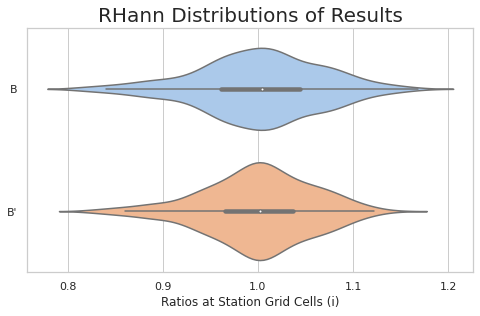

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 79.9290458377529 
UAA_station_mean 77.4 
Combined 78.66452291887646


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: %


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)